In [1]:
import sys
from pathlib import Path

current = Path().resolve()
while not (current / "src").exists():
    current = current.parent

sys.path.append(str(current))


In [2]:
# Common setup for evaluation notebooks
# - Finds project root
# - Sets device
# - Defines standard grayscale transform

import torch
import matplotlib.pyplot as plt
from pathlib import Path
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from src.models.vae import ConvVAE

# Robust project root detection
current = Path().resolve()
while not (current / "src").exists():
    current = current.parent

print("Project root:", current)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Standard grayscale transform (used across all datasets)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

/usr/local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Project root: /workspace
Using device: cpu


Evaluating MNIST


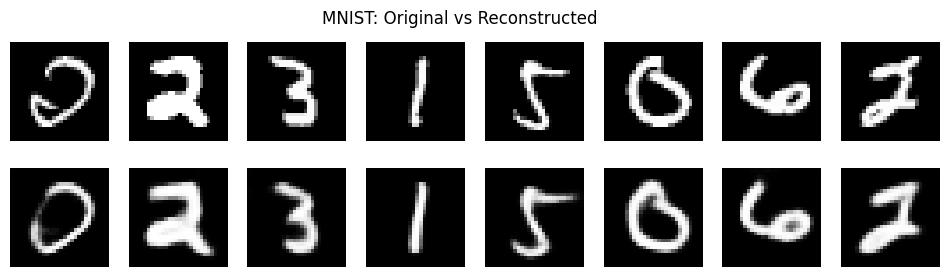

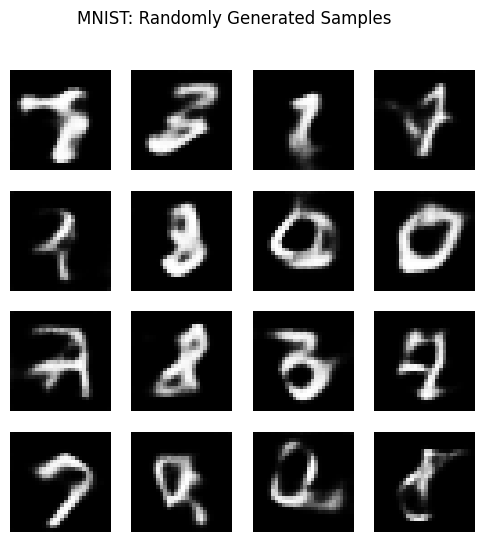

In [3]:
# MNIST Evaluation
# Purpose:
# 1. Show reconstruction capability (input vs output)
# 2. Show random image generation from latent space

print("Evaluating MNIST")

# Load MNIST test data
mnist = datasets.MNIST(
    root=current / "data" / "raw",
    train=False,
    download=True,
    transform=transform
)

loader = DataLoader(mnist, batch_size=8, shuffle=True)

# Load trained MNIST VAE
model = ConvVAE(latent_dim=32).to(device)
model.load_state_dict(
    torch.load(current / "checkpoints" / "grayscale" / "vae_mnist.pt", map_location=device)
)
model.eval()

# ---------------- Reconstruction ----------------
x, _ = next(iter(loader))
x = x.to(device)

with torch.no_grad():
    recon, _, _ = model(x)

# De-normalize for visualization
x_vis = (x + 1) / 2
recon_vis = (recon + 1) / 2

fig, axes = plt.subplots(2, 8, figsize=(12, 3))
for i in range(8):
    axes[0, i].imshow(x_vis[i, 0].cpu(), cmap="gray")
    axes[1, i].imshow(recon_vis[i, 0].cpu(), cmap="gray")
    axes[0, i].axis("off")
    axes[1, i].axis("off")

axes[0, 0].set_ylabel("Original")
axes[1, 0].set_ylabel("Reconstructed")
plt.suptitle("MNIST: Original vs Reconstructed")
plt.show()

# ---------------- Random Generation ----------------
z = torch.randn(16, 32).to(device)
with torch.no_grad():
    samples = model.decoder(z)

samples = (samples + 1) / 2

fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i in range(16):
    axes[i // 4, i % 4].imshow(samples[i, 0].cpu(), cmap="gray")
    axes[i // 4, i % 4].axis("off")

plt.suptitle("MNIST: Randomly Generated Samples")
plt.show()


# Observation (for report / viva):
# - Reconstructed digits preserve identity but appear smoother.
# - This blur is expected in VAEs due to probabilistic decoding
#   and KL-divergence regularization.
# - Later improvements can include:
#   * lower beta values
#   * deeper decoder
#   * perceptual or adversarial loss

Evaluating FashionMNIST


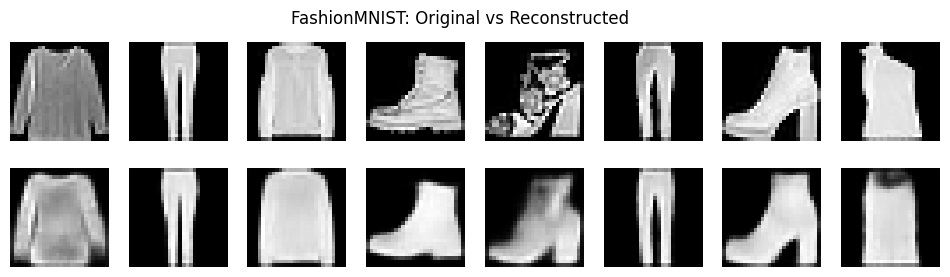

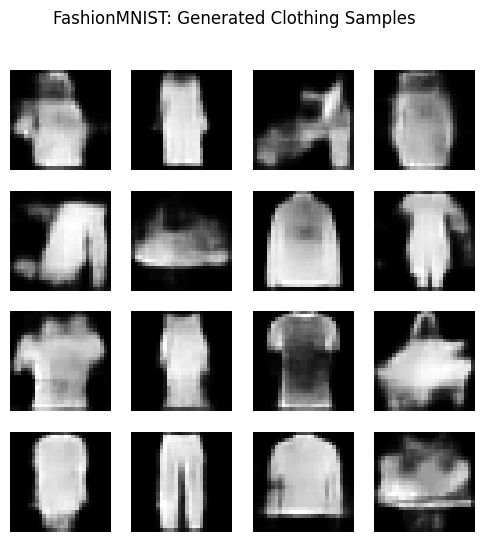

In [4]:
# FashionMNIST Evaluation
# Purpose:
# - Demonstrate style learning on more complex shapes
# - Stronger visual evidence than digits

print("Evaluating FashionMNIST")

fashion = datasets.FashionMNIST(
    root=current / "data" / "raw",
    train=False,
    download=True,
    transform=transform
)

loader = DataLoader(fashion, batch_size=8, shuffle=True)

model = ConvVAE(latent_dim=32).to(device)
model.load_state_dict(
    torch.load(current / "checkpoints" / "grayscale" / "vae_fashion.pt", map_location=device)
)
model.eval()

# ---------------- Reconstruction ----------------
x, _ = next(iter(loader))
x = x.to(device)

with torch.no_grad():
    recon, _, _ = model(x)

x_vis = (x + 1) / 2
recon_vis = (recon + 1) / 2

fig, axes = plt.subplots(2, 8, figsize=(12, 3))
for i in range(8):
    axes[0, i].imshow(x_vis[i, 0].cpu(), cmap="gray")
    axes[1, i].imshow(recon_vis[i, 0].cpu(), cmap="gray")
    axes[0, i].axis("off")
    axes[1, i].axis("off")

axes[0, 0].set_ylabel("Original")
axes[1, 0].set_ylabel("Reconstructed")
plt.suptitle("FashionMNIST: Original vs Reconstructed")
plt.show()

# ---------------- Random Generation ----------------
z = torch.randn(16, 32).to(device)
with torch.no_grad():
    samples = model.decoder(z)

samples = (samples + 1) / 2

fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i in range(16):
    axes[i // 4, i % 4].imshow(samples[i, 0].cpu(), cmap="gray")
    axes[i // 4, i % 4].axis("off")

plt.suptitle("FashionMNIST: Generated Clothing Samples")
plt.show()


# Observation:
# - Reconstructions retain garment shape but lose fine texture.
# - Generated samples show clothing-like silhouettes.
# - This demonstrates style learning beyond digits.
# - Future work:
#   * train longer
#   * increase latent dimension
#   * use multi-scale decoders


Evaluating EMNIST


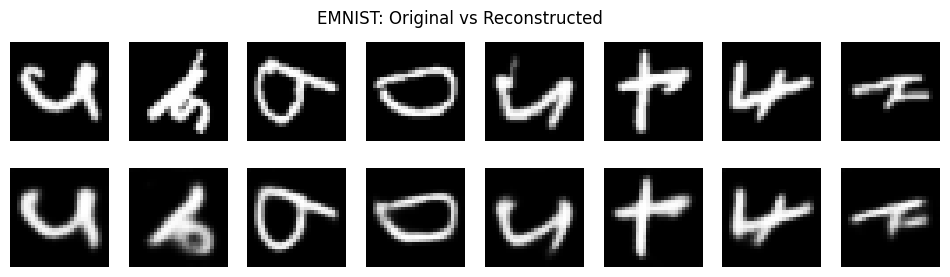

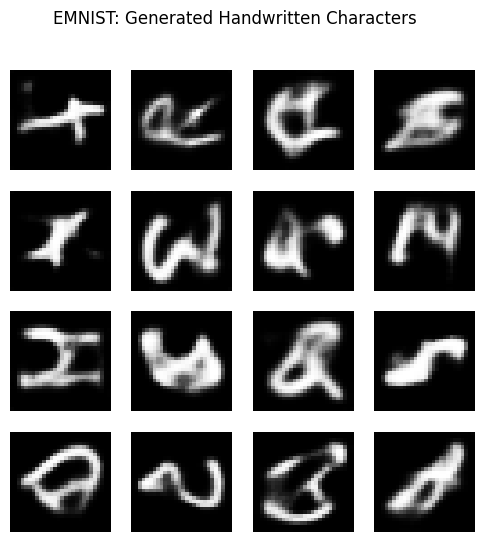

In [5]:
# EMNIST Evaluation
# Purpose:
# - Show handwriting style learning across alphabets + digits
# - Higher diversity and complexity

print("Evaluating EMNIST")

emnist = datasets.EMNIST(
    root=current / "data" / "raw",
    split="balanced",
    train=False,
    download=True,
    transform=transform
)

loader = DataLoader(emnist, batch_size=8, shuffle=True)

model = ConvVAE(latent_dim=32).to(device)
model.load_state_dict(
    torch.load(current / "checkpoints" / "grayscale" / "vae_emnist.pt", map_location=device)
)
model.eval()

# ---------------- Reconstruction ----------------
x, _ = next(iter(loader))
x = x.to(device)

with torch.no_grad():
    recon, _, _ = model(x)

x_vis = (x + 1) / 2
recon_vis = (recon + 1) / 2

fig, axes = plt.subplots(2, 8, figsize=(12, 3))
for i in range(8):
    axes[0, i].imshow(x_vis[i, 0].cpu(), cmap="gray")
    axes[1, i].imshow(recon_vis[i, 0].cpu(), cmap="gray")
    axes[0, i].axis("off")
    axes[1, i].axis("off")

axes[0, 0].set_ylabel("Original")
axes[1, 0].set_ylabel("Reconstructed")
plt.suptitle("EMNIST: Original vs Reconstructed")
plt.show()

# ---------------- Random Generation ----------------
z = torch.randn(16, 32).to(device)
with torch.no_grad():
    samples = model.decoder(z)

samples = (samples + 1) / 2

fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i in range(16):
    axes[i // 4, i % 4].imshow(samples[i, 0].cpu(), cmap="gray")
    axes[i // 4, i % 4].axis("off")

plt.suptitle("EMNIST: Generated Handwritten Characters")
plt.show()


# Observation:
# - EMNIST reconstructions show more distortion due to
#   high intra-class variability.
# - Generated samples resemble handwritten symbols,
#   not exact letters — expected behavior for VAEs.
# - Future work:
#   * conditional VAE (character-conditioned)
#   * larger latent space
